# Display variational wavelet extraction results

In [36]:
import yaml, pickle, h5py, segyio
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

import pprint

%matplotlib notebook

In [2]:
from wtie.utils.logger import print_time_from_seconds
from wtie.modeling.utils import create_or_load_synthetic_dataset
from wtie.dataset import BaseDataset
from wtie.learning.model import VariationalEvaluator
from wtie.learning.network import VariationalNetwork
from wtie.processing.spectral import compute_spectrum

### Results folder

In [3]:
exp_name = 'var_2ms_02/'
result_dir = Path('../experiments/results') / exp_name

assert result_dir.is_dir()
print(result_dir)

../experiments/results/var_2ms_02


In [4]:
model_state_dict = result_dir / 'training' / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()
print(model_state_dict)

../experiments/results/var_2ms_02/training/trained_net_state_dict.pt


### Training values

In [5]:
with open(result_dir / 'parameters.yaml', 'r') as yaml_file:
    parameters = yaml.load(yaml_file, Loader=yaml.Loader)
pprint.pprint(parameters)

{'network': {'alpha_epoch_rate': 20,
             'alpha_init': 0.05,
             'alpha_max': 0.4,
             'alpha_scaling': 1.1,
             'batch_size': 512,
             'beta': 0.0,
             'learning_rate': 0.0025,
             'lr_decay_every_n_epoch': 80,
             'lr_decay_rate': 0.5,
             'max_epochs': 280,
             'min_delta_perc': 1,
             'network_kwargs': None,
             'patience': 20,
             'seismic_loss_type': 'mae',
             'tensorboard': False,
             'wavelet_loss_type': 'mae',
             'weight_decay': 0.003},
 'synthetic_dataset': {'dt': 0.002,
                       'from_scratch': False,
                       'h5_file': None,
                       'h5_group_training': None,
                       'h5_group_validation': None,
                       'noise': {'scale_max': 0.1, 'scale_min': 0.033},
                       'num_training_samples': 300000,
                       'num_validation_samples': 1024

## Network

In [6]:
with open(result_dir / 'training' / 'history.pkl', "rb") as fp:
    history = pickle.load(fp)

print(list(history))

nepochs = len(history['train_loss_total'])

print("\nTraining time (%d epochs):" % nepochs)
print_time_from_seconds(history['elapsed'])

['train_loss_total', 'val_loss_total', 'train_loss_wavelet', 'val_loss_wavelet', 'train_loss_seismic', 'val_loss_seismic', 'train_loss_variational', 'val_loss_variational', 'elapsed']

Training time (280 epochs):
DAYS:HOURS:MIN:SEC
0:3:4:27


In [7]:
#history['train_loss_variational']

In [8]:
def moving_average(x, n=7):
    avg = np.convolve(x, np.ones(n), 'same') / n
    avg[:n//2] = np.nan
    avg[-n//2:] = np.nan
    return avg

<IPython.core.display.Javascript object>


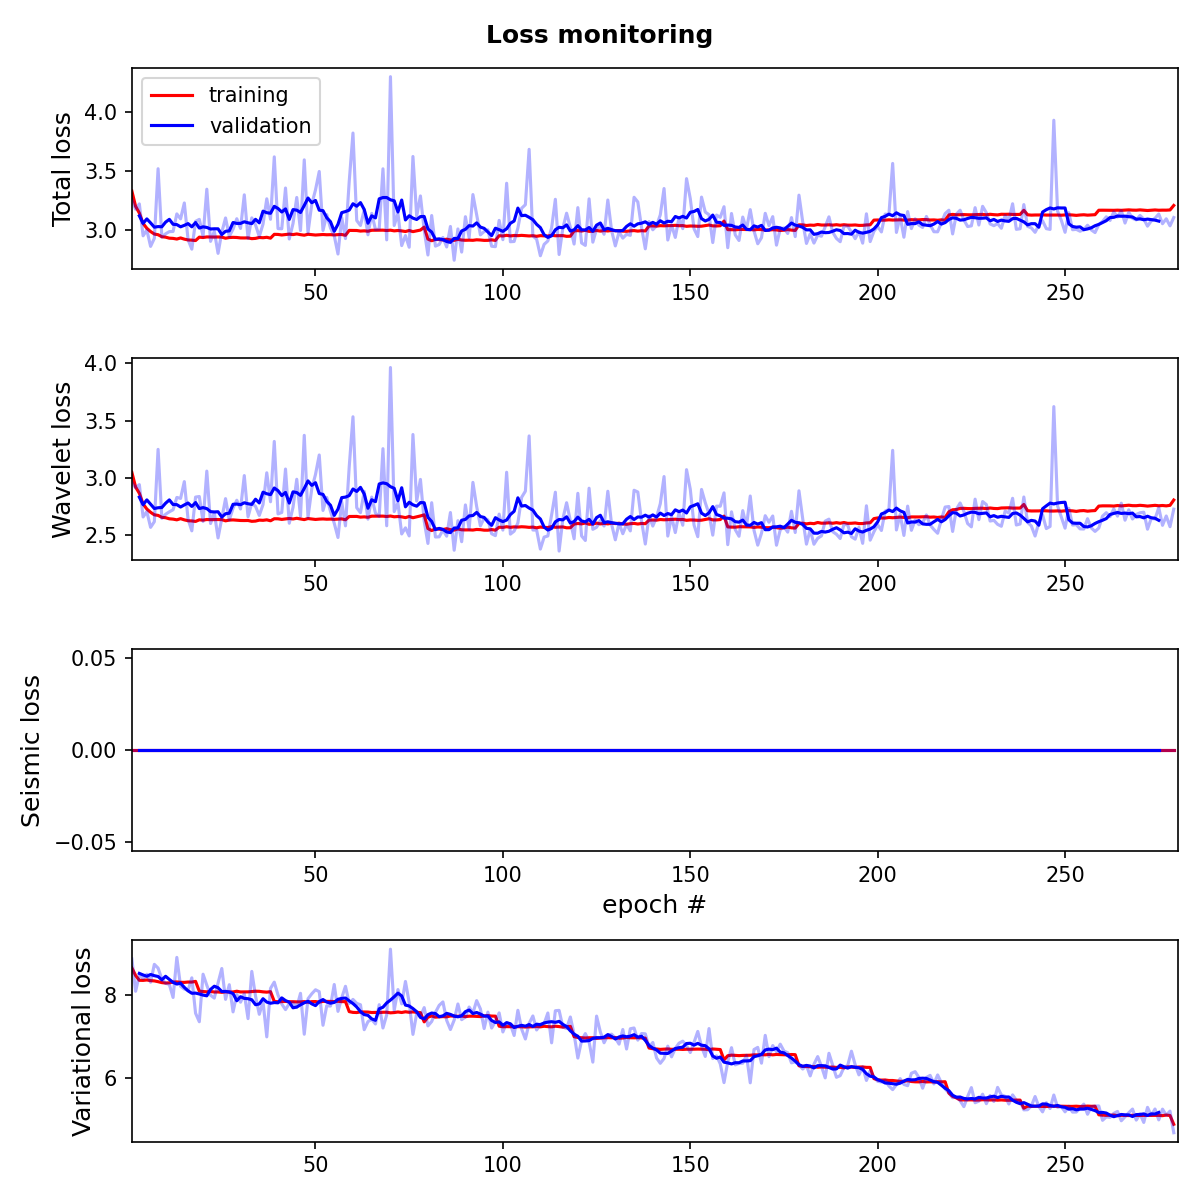

In [9]:
burn_epoch = 1

beta = parameters['network']['beta']
if beta is None: beta = 0.

fig, axes = plt.subplots(4,1, figsize=(8,8))

_vtl = history['val_loss_total']
axes[0].plot(range(burn_epoch,nepochs),history['train_loss_total'][burn_epoch:],'r',label='training')
axes[0].plot(range(burn_epoch,nepochs),moving_average(_vtl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[0].plot(range(burn_epoch,nepochs),_vtl[burn_epoch:],color='b',alpha=0.3)
axes[0].set_ylabel('Total loss',fontsize=12)
                   
_vwl = history['val_loss_wavelet']                   
axes[1].plot(range(burn_epoch,nepochs),history['train_loss_wavelet'][burn_epoch:],'r',label='training')
axes[1].plot(range(burn_epoch,nepochs),moving_average(_vwl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[1].plot(range(burn_epoch,nepochs),_vwl[burn_epoch:],color='b',alpha=0.3)
axes[1].set_ylabel('Wavelet loss',fontsize=12)    
                   
_vsl = history['val_loss_seismic']
axes[2].plot(range(burn_epoch,nepochs),np.array(history['train_loss_seismic'][burn_epoch:]),'r',label='training')
axes[2].plot(range(burn_epoch,nepochs),moving_average(_vsl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[2].plot(range(burn_epoch,nepochs),_vsl[burn_epoch:],color='b',alpha=0.3)
axes[2].set_ylabel('Seismic loss',fontsize=12)   

_vvl = history['val_loss_variational']
axes[3].plot(range(burn_epoch,nepochs),np.array(history['train_loss_variational'][burn_epoch:]),'r',label='training')
axes[3].plot(range(burn_epoch,nepochs),moving_average(_vvl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[3].plot(range(burn_epoch,nepochs),_vvl[burn_epoch:],color='b',alpha=0.3)
axes[3].set_ylabel('Variational loss',fontsize=12) 


for ax in axes:
    ax.set_xlim([burn_epoch,nepochs])
    
axes[0].legend(loc='best')
axes[2].set_xlabel('epoch #',fontsize=12)


fig.suptitle("Loss monitoring",fontweight='bold')
fig.tight_layout()

<IPython.core.display.Javascript object>


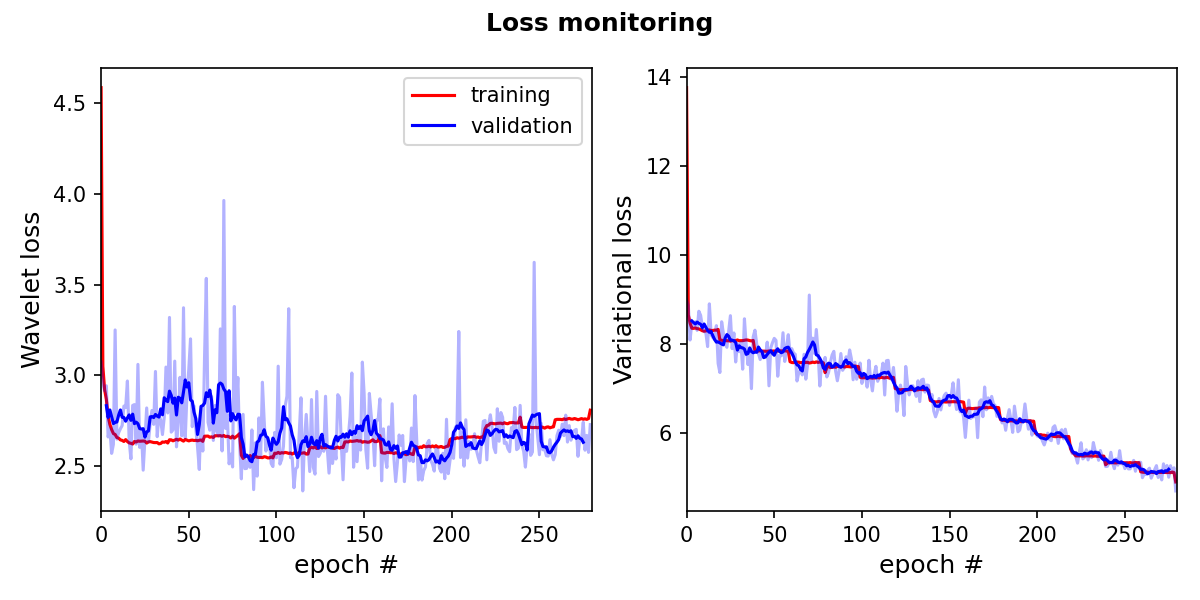

In [10]:
burn_epoch = 0

beta = parameters['network']['beta']
if beta is None: beta = 0.

fig, axes = plt.subplots(1,2, figsize=(8,4))


                   
_vwl = history['val_loss_wavelet']                   
axes[0].plot(range(burn_epoch,nepochs),history['train_loss_wavelet'][burn_epoch:],'r',label='training')
axes[0].plot(range(burn_epoch,nepochs),moving_average(_vwl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[0].plot(range(burn_epoch,nepochs),_vwl[burn_epoch:],color='b',alpha=0.3)
axes[0].set_ylabel('Wavelet loss',fontsize=12)    
                   
 

_vvl = history['val_loss_variational']
axes[1].plot(range(burn_epoch,nepochs),np.array(history['train_loss_variational'][burn_epoch:]),'r',label='training')
axes[1].plot(range(burn_epoch,nepochs),moving_average(_vvl)[burn_epoch:],color='b',alpha=1.,label='validation')
axes[1].plot(range(burn_epoch,nepochs),_vvl[burn_epoch:],color='b',alpha=0.3)
axes[1].set_ylabel('Variational loss',fontsize=12) 


for ax in axes:
    ax.set_xlim([burn_epoch,nepochs])
    
axes[0].legend(loc='best')
axes[0].set_xlabel('epoch #',fontsize=12)

axes[1].set_xlabel('epoch #',fontsize=12)


fig.suptitle("Loss monitoring",fontweight='bold')
fig.tight_layout()

### Load network params

In [11]:
net = VariationalNetwork(parameters['synthetic_dataset']['wavelet']['wavelet_size'],
        parameters['network']['network_kwargs'])

state_dict = result_dir / 'training' / 'trained_net_state_dict.pt'
evaluator = VariationalEvaluator(network=net,
                                 expected_sampling=parameters['synthetic_dataset']['dt'],
                                 state_dict=state_dict)

Loading network parameters from ../experiments/results/var_2ms_02/training/trained_net_state_dict.pt


/home/valentin/anaconda3/envs/wtie/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)



## Test extractions 

In [12]:
# files
h5_file = result_dir / 'training' / 'dataset.h5'
h5_group_training = 'synth01/training'
h5_group_validation = 'synth01/validation'

# I sometimes remove it if its too big
#assert h5_file.is_file()

# Overwrite to accelerate
parameters['synthetic_dataset']['num_training_samples'] = 1024

training_creator, validation_creator = create_or_load_synthetic_dataset(h5_file,
                                                                        h5_group_training,
                                                                        h5_group_validation,
                                                                        parameters['synthetic_dataset']
                                                                        )

base_training = BaseDataset(training_creator)
base_validation = BaseDataset(validation_creator)

dt = base_training.dt
wlt_t = base_training.wavelet_t
ref_t = base_training.reflectivity_t

../experiments/results/var_2ms_02/training/dataset.h5 -> synth01/training dataset already exists.
../experiments/results/var_2ms_02/training/dataset.h5 -> synth01/validation dataset already exists.


## Expected wavelet

### vizualize training data

<IPython.core.display.Javascript object>


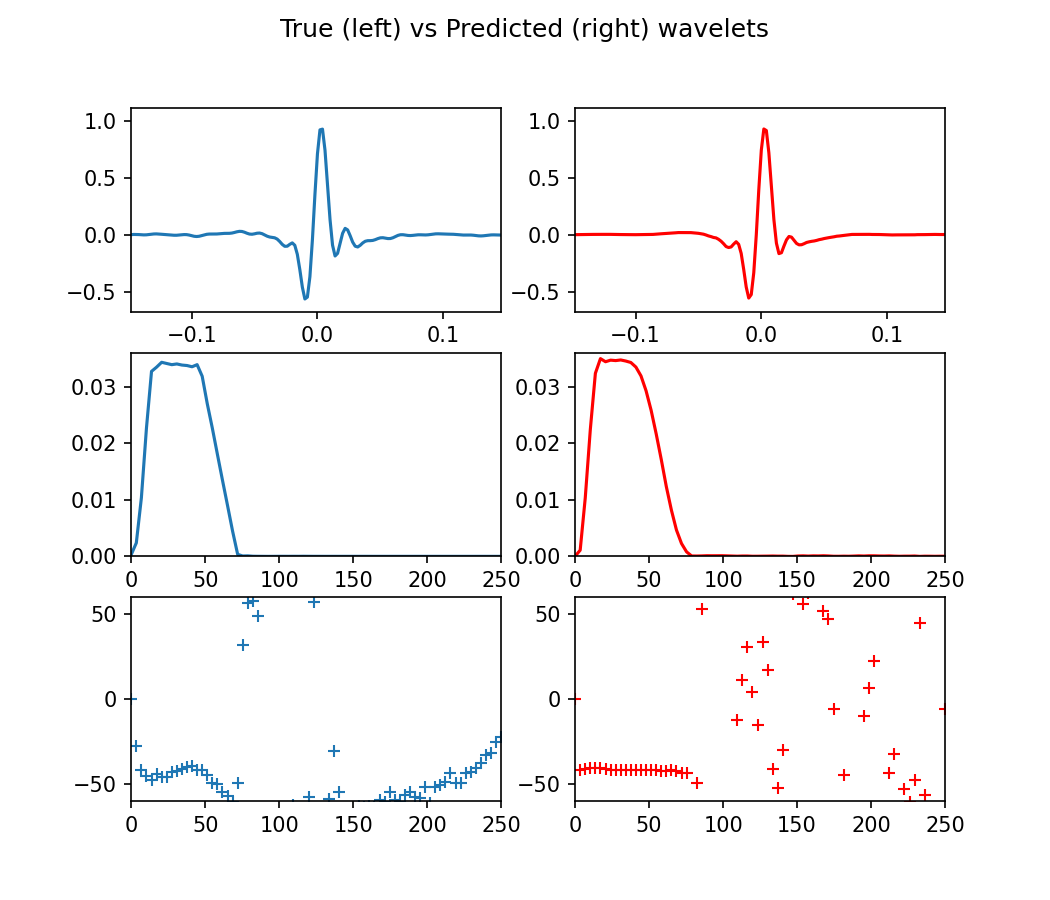

Text(0.5, 0.98, 'True (left) vs Predicted (right) wavelets')

In [13]:
idx = 0


t_batch = base_training[idx]

pred_wlt = evaluator.expected_wavelet(seismic=base_training.prepare_for_network_input(t_batch['seismic']),
                    reflectivity=base_training.prepare_for_network_input(t_batch['reflectivity']))


ff, ampl, _, phase = compute_spectrum(t_batch['wavelet'], dt, to_degree=True)
ff2, ampl2, _, phase2 = compute_spectrum(pred_wlt, dt, to_degree=True)




fig, axes = plt.subplots(3,2,figsize=(7,6))

# wavelets
axes[0,0].plot(wlt_t, t_batch['wavelet'])
axes[0,1].plot(wlt_t, pred_wlt, 'r')
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlim((wlt_t[0], wlt_t[-1]))
    ax.set_ylim((1.2*t_batch['wavelet'].min(), 1.2*t_batch['wavelet'].max()))

# amplitudes
axes[1,0].plot(ff, ampl,'-')
axes[1,1].plot(ff2, ampl2,'r-')
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((0,1.05*ampl.max()))

# phases
axes[2,0].plot(ff, phase, '+')
axes[2,1].plot(ff2, phase2, 'r+')
for ax in [axes[2,0], axes[2,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((-60,60))
    
fig.suptitle("True (left) vs Predicted (right) wavelets")

#axes[1,0].set_xlim([0,125])
#axes[1].set_ylim([-20,20])

<IPython.core.display.Javascript object>


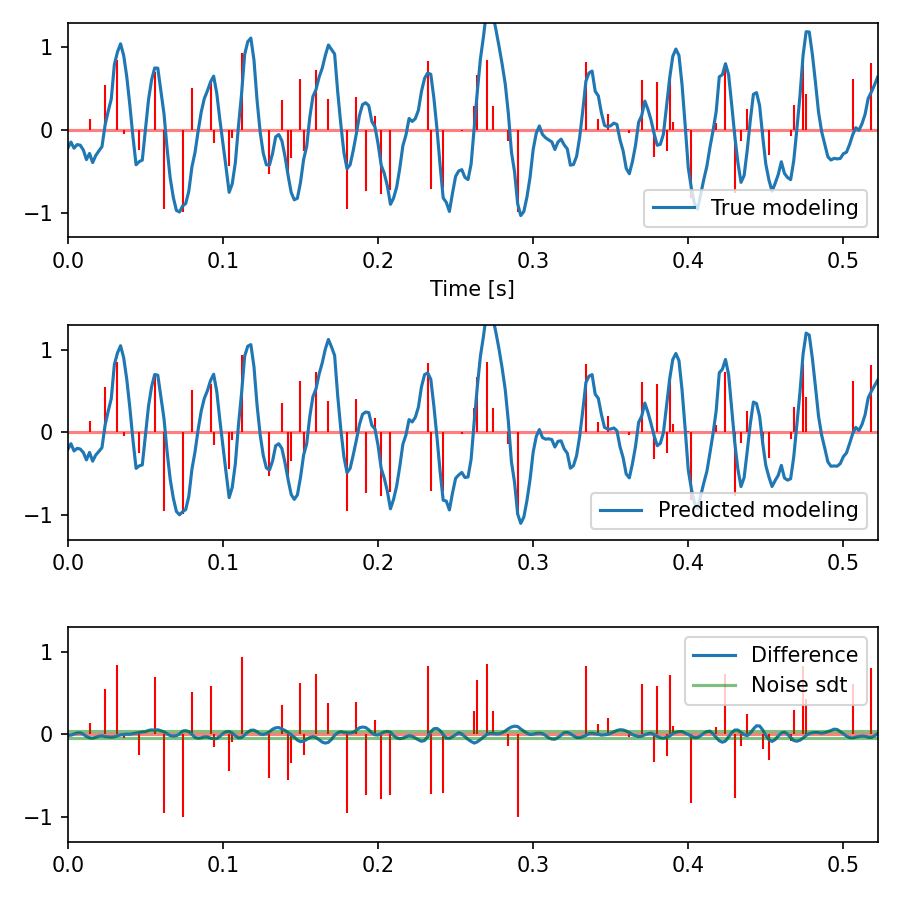

In [14]:
ref = t_batch['reflectivity']
x_picks = np.where(ref!=0)[0]
y_picks = ref[ref != 0.]

pred_seismic = base_training.data_creator.modeler(wavelet=pred_wlt,
                                                  reflectivity=ref,
                                                  noise=t_batch['noise'])

fig,axes = plt.subplots(3,1, figsize=(6,6))


axes[0].plot(ref_t, 0*ref, 'r', alpha=0.5)
axes[0].plot(ref_t, t_batch['seismic'], lw=1.5, label='True modeling')
#axes[0].plot(ref_t, noise, 'g', alpha=0.3, lw=1.)
for i in range(len(x_picks)):
    axes[0].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
   


axes[1].plot(ref_t, 0*ref, 'r', alpha=0.5)
axes[1].plot(ref_t, pred_seismic, lw=1.5, label='Predicted modeling')
for i in range(len(x_picks)):
    axes[1].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
    
axes[2].plot(ref_t, 0*ref, 'r', alpha=0.5)
axes[2].plot(ref_t, t_batch['seismic'] - pred_seismic, lw=1.5, label='Difference')
_std_noise = np.std(t_batch['noise'])
axes[2].plot(ref_t, _std_noise*np.ones_like(pred_seismic), lw=1.5, color='g', alpha=0.5, label='Noise sdt')
axes[2].plot(ref_t, -_std_noise*np.ones_like(pred_seismic), lw=1.5, color='g', alpha=0.5)
for i in range(len(x_picks)):
    axes[2].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)


for ax in axes:
    ax.set_xlim([ref_t[0],ref_t[-1]])
    ax.set_ylim([-1.3,1.3])
    ax.legend(loc='best')
    
axes[0].set_xlabel("Time [s]")

plt.tight_layout()

### vizualize random data

<IPython.core.display.Javascript object>


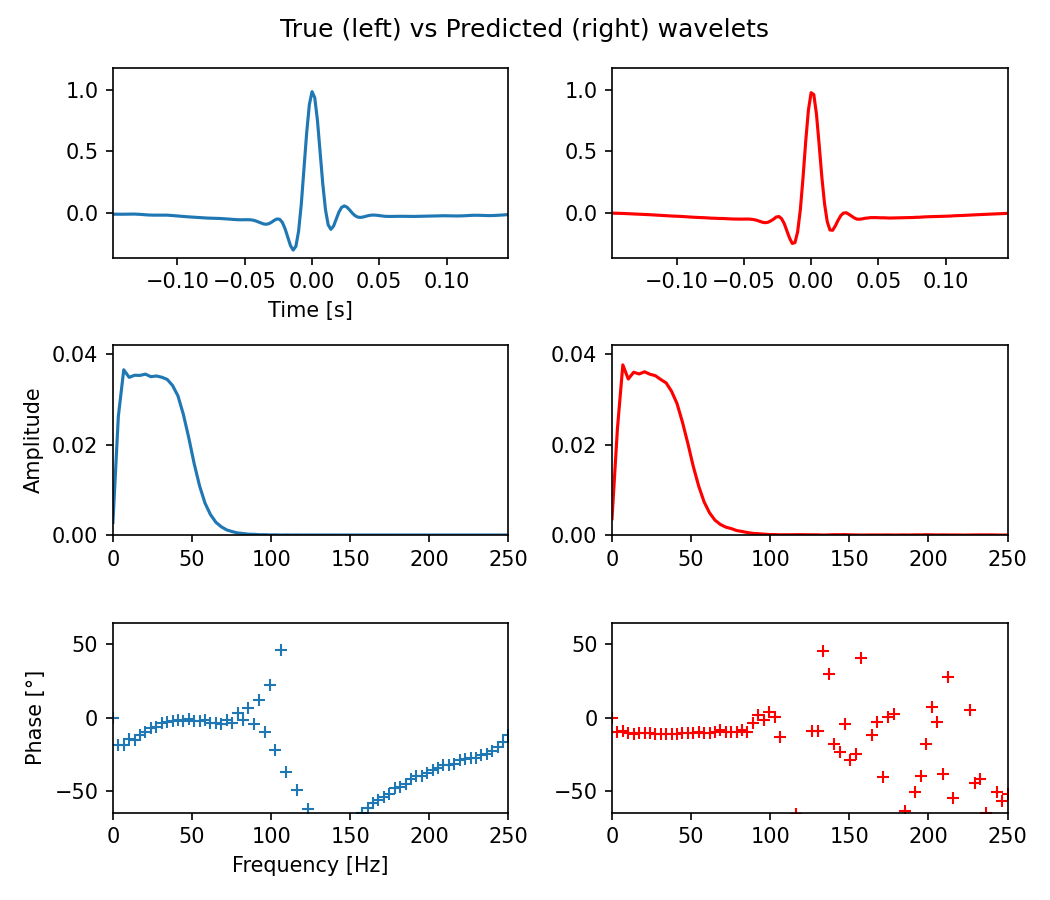

In [15]:
r_wlt = training_creator.wavelet_callable()
r_ref = training_creator.reflectivity_callable()
r_noise = training_creator.noise_callable()

r_seismic = training_creator.modeler(wavelet=r_wlt.y, reflectivity=r_ref, noise=r_noise)


r_pred_wlt = evaluator.expected_wavelet(seismic=base_training.prepare_for_network_input(r_seismic),
                    reflectivity=base_training.prepare_for_network_input(r_ref))



ff, ampl, _, phase = compute_spectrum(r_wlt.y, dt, to_degree=True)
ff2, ampl2, _, phase2 = compute_spectrum(r_pred_wlt, dt, to_degree=True)



fig, axes = plt.subplots(3,2,figsize=(7,6))

axes[0,0].plot(wlt_t, r_wlt.y)
axes[0,1].plot(wlt_t, r_pred_wlt, 'r')
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlim((wlt_t[0], wlt_t[-1]))
    ax.set_ylim((1.2*r_wlt.y.min(), 1.2*r_wlt.y.max()))


axes[1,0].plot(ff, ampl,'-')
axes[1,1].plot(ff2, ampl2,'r-')
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((0,1.15*ampl.max()))



#axes[2,0].plot(ff, np.rad2deg(phase), '+')
#axes[2,1].plot(ff2, np.rad2deg(phase2), 'r+')
axes[2,0].plot(ff, phase, '+')
axes[2,1].plot(ff2, phase2, 'r+')
for ax in [axes[2,0], axes[2,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((-65,65))

#axes[1,0].set_xlim([0,125])
#axes[1].set_ylim([-20,20])

axes[0,0].set_xlabel("Time [s]")
axes[1,0].set_ylabel("Amplitude")
axes[2,0].set_ylabel("Phase [°]")
axes[2,0].set_xlabel("Frequency [Hz]")

fig.suptitle("True (left) vs Predicted (right) wavelets")


fig.tight_layout()

<IPython.core.display.Javascript object>


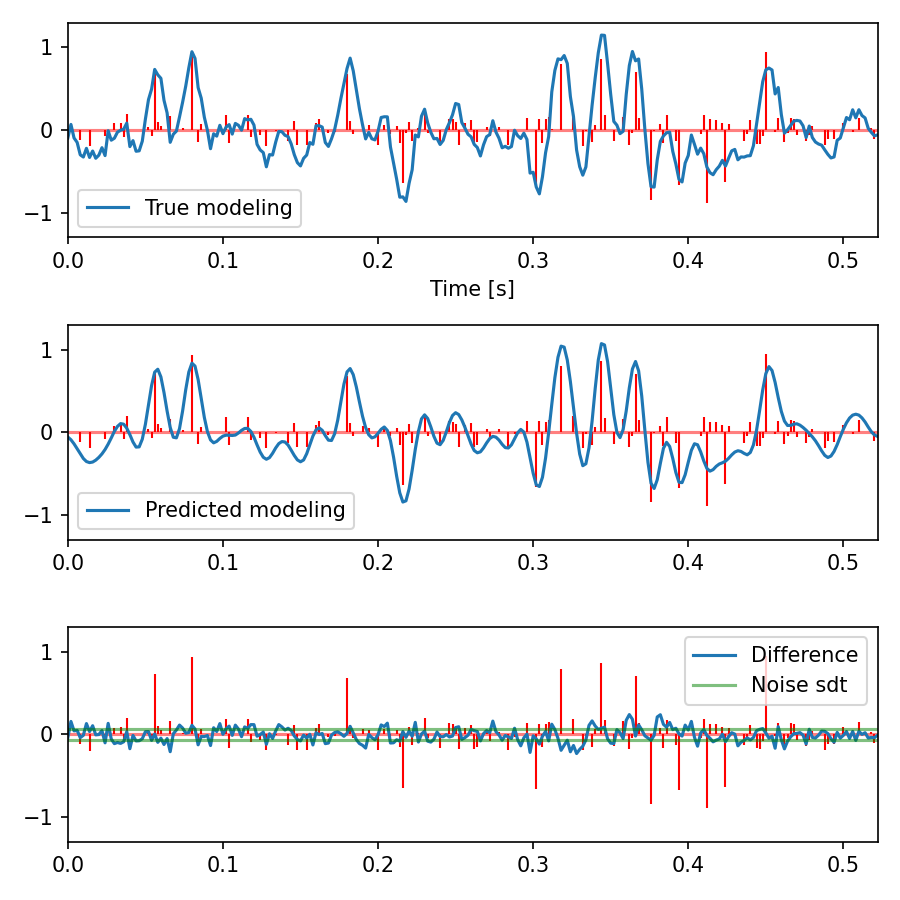

In [16]:
x_picks = np.where(r_ref!=0)[0]
y_picks = r_ref[r_ref != 0.]

r_pred_seismic = base_training.data_creator.modeler(wavelet=r_pred_wlt,
                                                  reflectivity=r_ref)

fig,axes = plt.subplots(3,1, figsize=(6,6))


axes[0].plot(ref_t, 0*r_ref, 'r', alpha=0.5)
axes[0].plot(ref_t, r_seismic, lw=1.5, label='True modeling')
#axes[0].plot(ref_t, noise, 'g', alpha=0.3, lw=1.)
for i in range(len(x_picks)):
    axes[0].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
   


axes[1].plot(ref_t, 0*r_ref, 'r', alpha=0.5)
axes[1].plot(ref_t, r_pred_seismic, lw=1.5, label='Predicted modeling')
for i in range(len(x_picks)):
    axes[1].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
    
axes[2].plot(ref_t, 0*ref, 'r', alpha=0.5)
axes[2].plot(ref_t, r_seismic - r_pred_seismic, lw=1.5, label='Difference')
_std_noise = np.std(r_noise)
axes[2].plot(ref_t, _std_noise*np.ones_like(r_seismic), lw=1.5, color='g', alpha=0.5, label='Noise sdt')
axes[2].plot(ref_t, -_std_noise*np.ones_like(r_seismic), lw=1.5, color='g', alpha=0.5)


for i in range(len(x_picks)):
    axes[2].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)


for ax in axes:
    ax.set_xlim([ref_t[0],ref_t[-1]])
    ax.set_ylim([-1.3,1.3])
    ax.legend(loc='best')
    
axes[0].set_xlabel("Time [s]")

plt.tight_layout()

### Impulse response test

In [17]:
from wtie.modeling.reflectivity import SpikeReflectivity

<IPython.core.display.Javascript object>


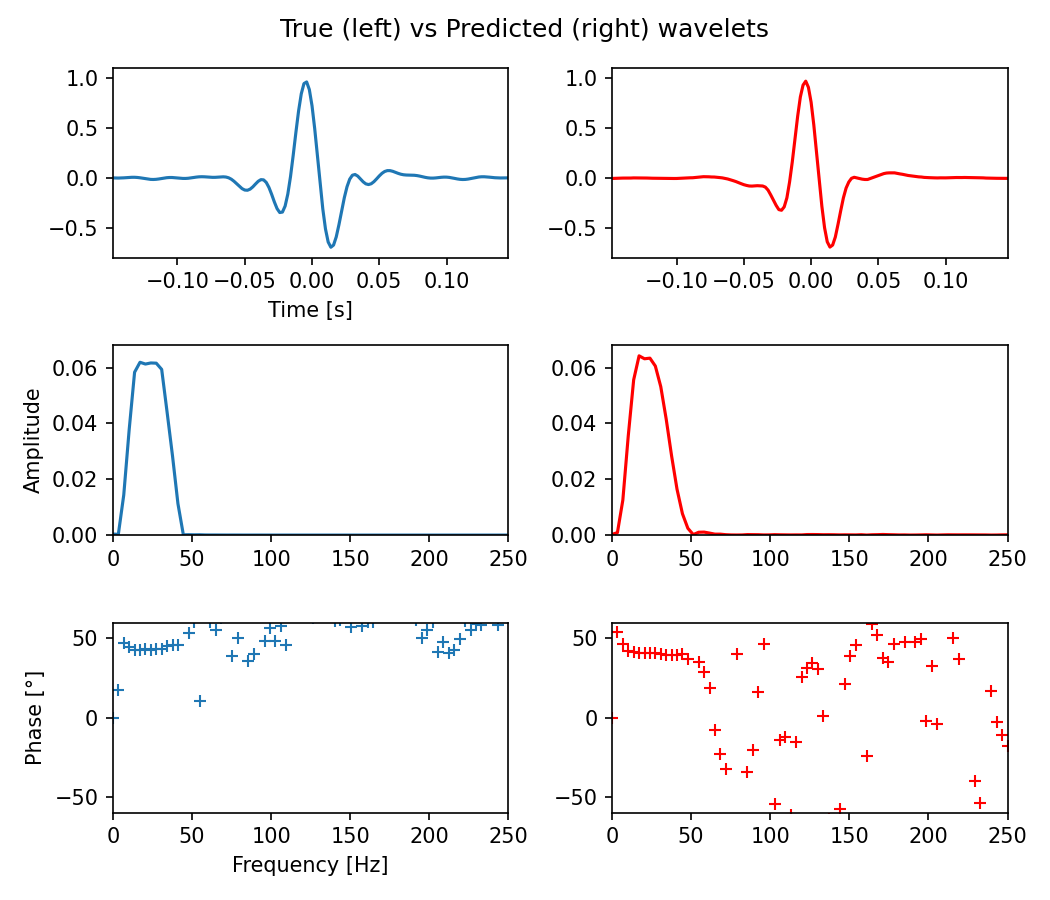

In [18]:
ref_spike = SpikeReflectivity(base_training.reflectivity_size)()

s_wavelet = training_creator.wavelet_callable()
s_wavelet = s_wavelet.y


s_noise = None #training_creator.noise_callable()

s_seismic = training_creator.modeler(wavelet=s_wavelet, reflectivity=ref_spike, noise=s_noise)


s_pred_wlt = evaluator.expected_wavelet(seismic=base_training.prepare_for_network_input(s_seismic),
                    reflectivity=base_training.prepare_for_network_input(ref_spike),
                    squeeze=True)



ff, ampl, _, phase = compute_spectrum(s_wavelet, dt, to_degree=True)
ff2, ampl2, _, phase2 = compute_spectrum(s_pred_wlt, dt, to_degree=True)




fig, axes = plt.subplots(3,2,figsize=(7,6))

axes[0,0].plot(wlt_t, s_wavelet)
axes[0,1].plot(wlt_t, s_pred_wlt, 'r')
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlim((wlt_t[0], wlt_t[-1]))
    ax.set_ylim((1.15*s_wavelet.min(), 1.15*s_wavelet.max()))


axes[1,0].plot(ff, ampl,'-')
axes[1,1].plot(ff2, ampl2,'r-')
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((0,1.1*ampl.max()))



#axes[2,0].plot(ff, np.rad2deg(phase), '+')
#axes[2,1].plot(ff2, np.rad2deg(phase2), 'r+')
axes[2,0].plot(ff, phase, '+')
axes[2,1].plot(ff2, phase2, 'r+')
for ax in [axes[2,0], axes[2,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((-60,60))
    
axes[0,0].set_xlabel("Time [s]")
axes[1,0].set_ylabel("Amplitude")
axes[2,0].set_ylabel("Phase [°]")
axes[2,0].set_xlabel("Frequency [Hz]")

fig.suptitle("True (left) vs Predicted (right) wavelets")


fig.tight_layout()

## Variational distribution

<IPython.core.display.Javascript object>


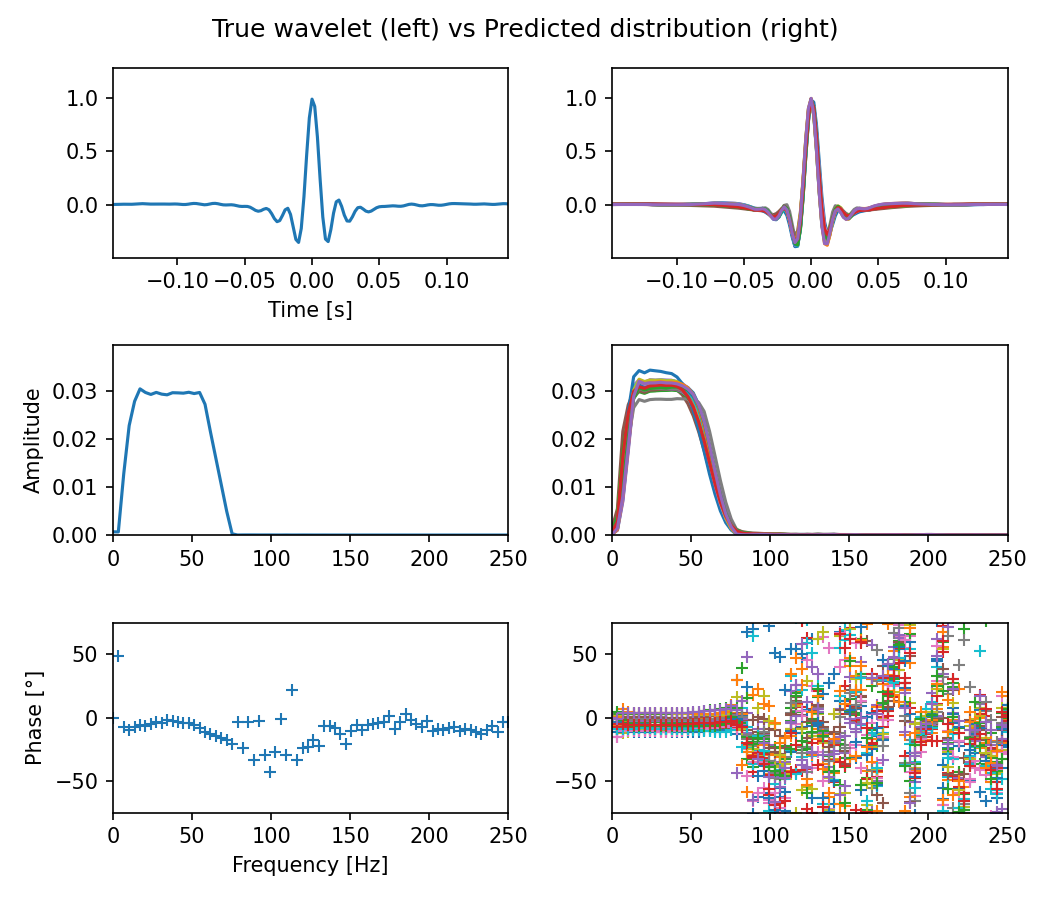

In [19]:
r_wlt = training_creator.wavelet_callable()
r_ref = training_creator.reflectivity_callable()
r_noise = training_creator.noise_callable()

r_seismic = training_creator.modeler(wavelet=r_wlt.y, reflectivity=r_ref, noise=r_noise)

r_pred_wavelets = evaluator.sample_n_times(seismic=base_training.prepare_for_network_input(r_seismic),
                    reflectivity=base_training.prepare_for_network_input(r_ref), n=25)



ff, ampl, _, phase = compute_spectrum(r_wlt.y, dt, to_degree=True)




fig, axes = plt.subplots(3,2,figsize=(7,6))

axes[0,0].plot(wlt_t, r_wlt.y)
axes[1,0].plot(ff, ampl,'-')
axes[2,0].plot(ff, phase, '+')

for i in range(len(r_pred_wavelets)):
    ff2, ampl2, _, phase2 = compute_spectrum(r_pred_wavelets[i], dt, to_degree=True)

    axes[0,1].plot(wlt_t, r_pred_wavelets[i])
    axes[1,1].plot(ff2, ampl2,'-')
    axes[2,1].plot(ff2, phase2, '+')


for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlim((wlt_t[0], wlt_t[-1]))
    ax.set_ylim((1.4*r_wlt.y.min(), 1.3*r_wlt.y.max()))
    
    
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((0,1.3*ampl.max()))
    
for ax in [axes[2,0], axes[2,1]]:
    ax.set_xlim((ff[0],ff[-1]))
    ax.set_ylim((-75,75))
    


axes[0,0].set_xlabel("Time [s]")
axes[1,0].set_ylabel("Amplitude")
axes[2,0].set_ylabel("Phase [°]")
axes[2,0].set_xlabel("Frequency [Hz]")

fig.suptitle("True wavelet (left) vs Predicted distribution (right)")


fig.tight_layout()

<IPython.core.display.Javascript object>


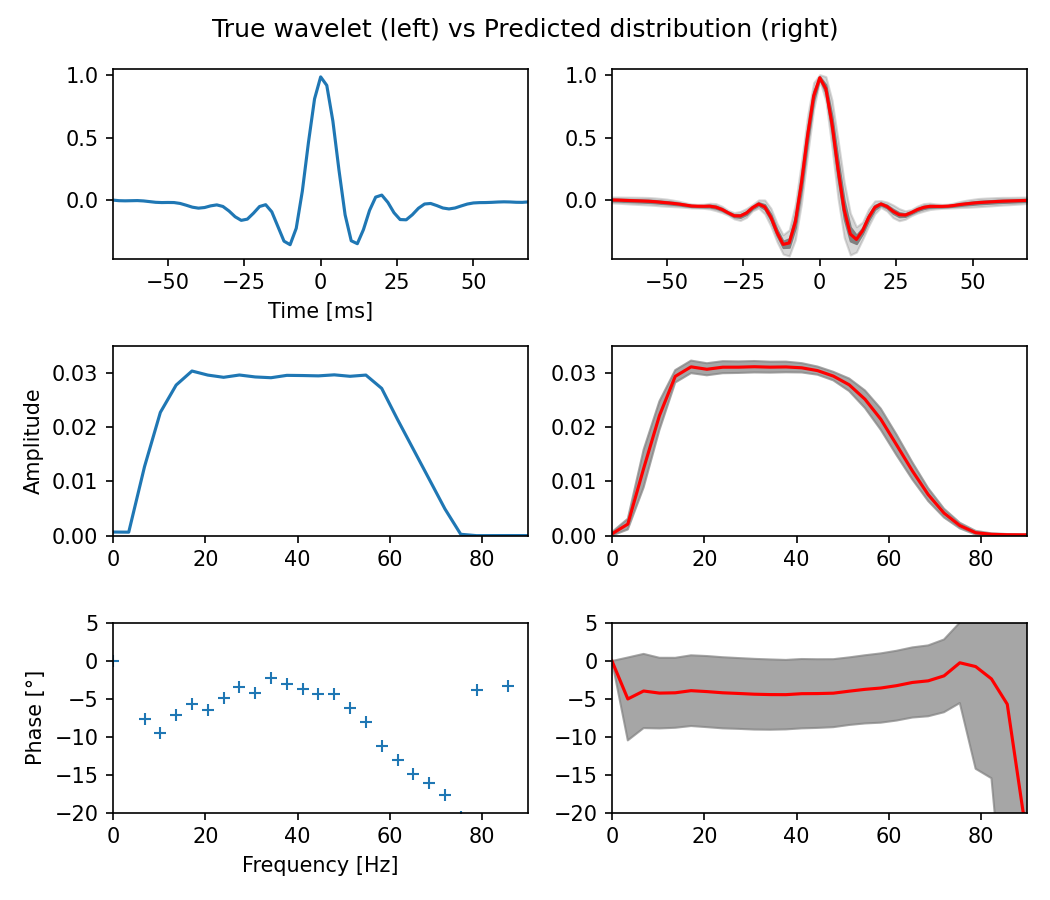

In [43]:
fig, axes = plt.subplots(3,2,figsize=(7,6))

burn = 40
axes[0,0].plot(1000*wlt_t, r_wlt.y)
axes[1,0].plot(ff, ampl,'-')
axes[2,0].plot(ff, phase, '+')

ampl2 = []
phase2 = []

for i in range(len(r_pred_wavelets)):
    ff2, _ampl2, _, _phase2 = compute_spectrum(r_pred_wavelets[i], dt, to_degree=True)
    ampl2.append(_ampl2)
    phase2.append(_phase2)
    
ampl2 = np.array(ampl2)
phase2 = np.array(phase2)
r_pred_wavelets = np.array(r_pred_wavelets)

_mean = np.mean(r_pred_wavelets, axis=0)
_std = np.std(r_pred_wavelets, axis=0)
axes[0,1].plot(1000*wlt_t, _mean, color='r')
axes[0,1].fill_between(1000*wlt_t, _mean-_std, _mean+_std, color='gray', alpha=1.)
axes[0,1].fill_between(1000*wlt_t, _mean-3*_std, _mean+3*_std, color='gray', alpha=0.3)



_mean = np.mean(ampl2, axis=0)
_std = np.std(ampl2, axis=0)
axes[1,1].plot(ff2, _mean, color='r')
axes[1,1].fill_between(ff2, _mean-_std, _mean+_std, color='gray', alpha=0.7)


#axes[2,1].plot(ff2, np.mean(phase2, axis=0), '+')
_mean = np.mean(phase2, axis=0)
_std = np.std(phase2, axis=0)
axes[2,1].plot(ff2, _mean, color='r')
axes[2,1].fill_between(ff2, _mean-_std, _mean+_std, color='gray', alpha=0.7)

fmax = 90
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim((ff[0],fmax))
    ax.set_ylim((0,1.15*ampl.max()))
    
for ax in [axes[2,0], axes[2,1]]:
    ax.set_xlim((ff[0],fmax))
    #ax.set_ylim((-75,75))
    ax.set_ylim((-20,5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlim((1000*wlt_t[burn], 1000*wlt_t[-burn]))
    ax.set_ylim((1.32*r_wlt.y.min(), 1.06*r_wlt.y.max()))

axes[0,0].set_xlabel("Time [ms]")
axes[1,0].set_ylabel("Amplitude")
axes[2,0].set_ylabel("Phase [°]")
axes[2,0].set_xlabel("Frequency [Hz]")

fig.suptitle("True wavelet (left) vs Predicted distribution (right)")


fig.tight_layout()

<IPython.core.display.Javascript object>


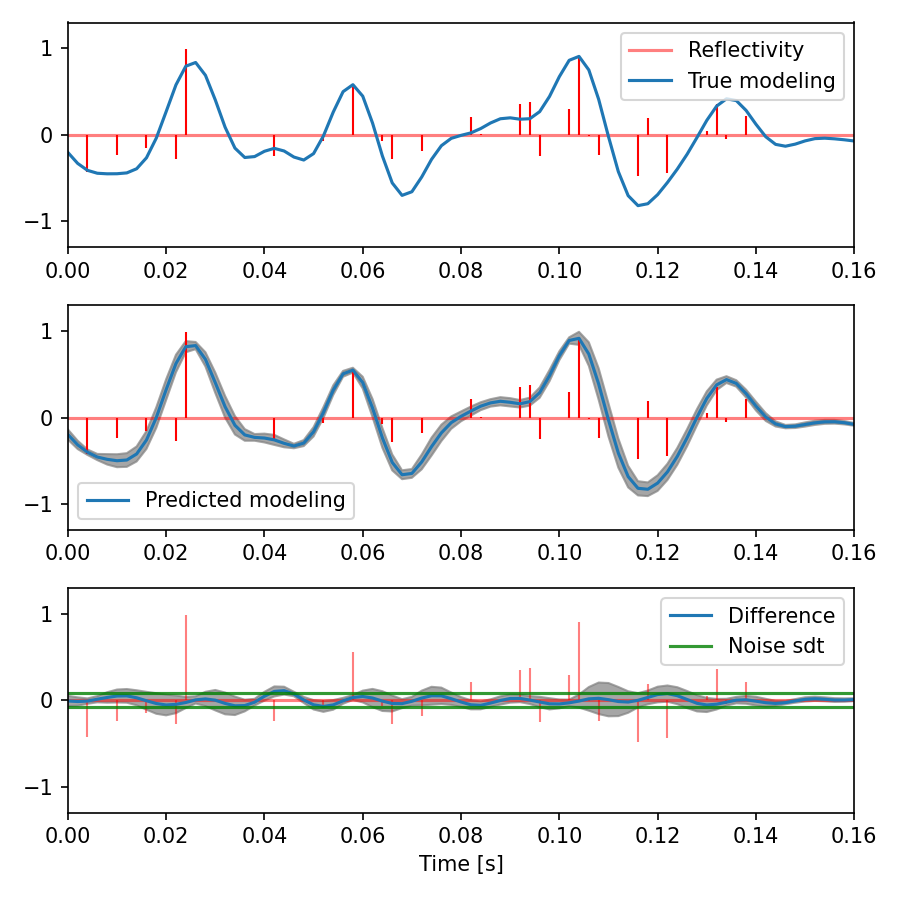

In [49]:
x_picks = np.where(r_ref!=0)[0]
y_picks = r_ref[r_ref != 0.]

t_start_idx = 0
t_end_idx = 80

r_seismic_no_noise = training_creator.modeler(wavelet=r_wlt.y, reflectivity=r_ref, noise=None)

r_pred_seismics = []
for i in range(len(r_pred_wavelets)):
    r_pred_seismics.append(base_training.data_creator.modeler(wavelet=r_pred_wavelets[i],
                                                  reflectivity=r_ref))

r_pred_seismics_mean = np.mean(np.array(r_pred_seismics), axis=0)
r_pred_seismics_std = np.std(np.array(r_pred_seismics), axis=0)


fig,axes = plt.subplots(3,1, figsize=(6,6))


axes[0].plot(ref_t, 0*r_ref, 'r', alpha=0.5, label='Reflectivity')
axes[0].plot(ref_t, r_seismic_no_noise, lw=1.5, label='True modeling')
#axes[0].plot(ref_t,  r_noise, lw=1.5, color='g', alpha=0.5, label='Noise')
for i in range(len(x_picks)):
    axes[0].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
   


axes[1].plot(ref_t, 0*r_ref, 'r', alpha=0.5)
axes[1].plot(ref_t, r_pred_seismics_mean, lw=1.5, label='Predicted modeling')
axes[1].fill_between(ref_t, 
                     r_pred_seismics_mean-2*r_pred_seismics_std,
                     r_pred_seismics_mean+2*r_pred_seismics_std, color='gray', alpha=0.7)

for i in range(len(x_picks)):
    axes[1].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1.)
    
axes[2].plot(ref_t, 0*ref, 'r', alpha=0.5)
axes[2].plot(ref_t, r_seismic_no_noise - r_pred_seismics_mean, lw=1.5, label='Difference')
axes[2].fill_between(ref_t, 
                     r_seismic_no_noise - r_pred_seismics_mean-2*r_pred_seismics_std,
                     r_seismic_no_noise - r_pred_seismics_mean+2*r_pred_seismics_std, color='gray', alpha=0.7)

_std_noise = np.std(r_noise)
axes[2].plot(ref_t, _std_noise*np.ones_like(r_seismic), lw=1.5, color='g', alpha=0.8, label='Noise sdt')
axes[2].plot(ref_t, -_std_noise*np.ones_like(r_seismic), lw=1.5, color='g', alpha=0.8)


for i in range(len(x_picks)):
    axes[2].vlines(ref_t[x_picks[i]], ymin=0, ymax=y_picks[i], color='r', lw=1., alpha=0.5)


for ax in axes:
    ax.set_xlim([ref_t[t_start_idx],ref_t[t_end_idx]])
    ax.set_ylim([-1.3,1.3])
    ax.legend(loc='best')
    
axes[2].set_xlabel("Time [s]")

plt.tight_layout()